# TMDB Box Office Prediction

The notebook's purpose is to produce submissions for the [Kaggle Competition](https://www.kaggle.com/c/tmdb-box-office-prediction/data).
The challenge is to predict the box office of a movie, given a number of factors.

In [1]:
# data loading and neccessary libraries import
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
PATH = './datasets/tmdb-box-office-prediction/'
train_location = os.path.join(PATH, 'train.csv')
test_location = os.path.join(PATH, 'test.csv')

In [3]:
train_location

'./datasets/tmdb-box-office-prediction/train.csv'

In [4]:
train = pd.read_csv(train_location)
test = pd.read_csv(test_location)

In [5]:
train.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,...,3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,...,2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
id                       3000 non-null int64
belongs_to_collection    604 non-null object
budget                   3000 non-null int64
genres                   2993 non-null object
homepage                 946 non-null object
imdb_id                  3000 non-null object
original_language        3000 non-null object
original_title           3000 non-null object
overview                 2992 non-null object
popularity               3000 non-null float64
poster_path              2999 non-null object
production_companies     2844 non-null object
production_countries     2945 non-null object
release_date             3000 non-null object
runtime                  2998 non-null float64
spoken_languages         2980 non-null object
status                   3000 non-null object
tagline                  2403 non-null object
title                    3000 non-null object
Keywords             

## -- Plan of Attack
1. Clean the dataset, which includes a train and the test set.
2. Figure out which features correlate with the revenue.
3. Derive new features - this can occur at other times as well.
4. Evaluate and choose the best performing model.
5. Optimize the chosen model.

## 1. Cleaning Missing values


In [7]:
train.shape, test.shape

((3000, 23), (4398, 22))

### 1.1 Dealing with the missing data.
#### Working with the training set.

In [8]:
def get_missing_by_columns(df):
    '''
        Prints the columns with missing data and what percentage are they.
    '''
    total_missing = 0
    missing_cols = []
    for column in list(df.columns):
        missing = df[df[column].isnull()].shape[0]
        if missing > 0:
            missing_perc = missing / df.shape[0] * 100
            print(f'{column} has {np.round(missing_perc, 2)} % missing. Count missing: {missing}')
            total_missing += missing
            missing_cols.append(column)
    
    return total_missing, missing_cols

In [9]:
_, mis_col_list_train = get_missing_by_columns(train)

belongs_to_collection has 79.87 % missing. Count missing: 2396
genres has 0.23 % missing. Count missing: 7
homepage has 68.47 % missing. Count missing: 2054
overview has 0.27 % missing. Count missing: 8
poster_path has 0.03 % missing. Count missing: 1
production_companies has 5.2 % missing. Count missing: 156
production_countries has 1.83 % missing. Count missing: 55
runtime has 0.07 % missing. Count missing: 2
spoken_languages has 0.67 % missing. Count missing: 20
tagline has 19.9 % missing. Count missing: 597
Keywords has 9.2 % missing. Count missing: 276
cast has 0.43 % missing. Count missing: 13
crew has 0.53 % missing. Count missing: 16


In [10]:
def add_has_a_homepage(df):
    ''' Add a has_a_homepage feature to the dataframe.'''
    df['has_a_homepage'] = 0
    df.loc[~df['homepage'].isnull(),'has_a_homepage'] = 1
    df = df.drop(['homepage'], axis=1)
    
    return df

def add_part_of_collection(df):
    ''' Add a part of collection feature to the dataframe.'''
    df['part_of_collection'] = 0
    df.loc[~df['belongs_to_collection'].isnull(), 'part_of_collection'] = 1
    df = df.drop(['belongs_to_collection'], axis=1)
    
    return df

def add_has_a_tagline(df):
    ''' Add has_a_tagline feature to the dataframe'''
    df['has_a_tagline'] = 0
    df.loc[~df['tagline'].isnull(), 'has_a_tagline'] = 1
    df = df.drop(['tagline'], axis=1)
    
    return df

def add_number_of_keyword(df):
    '''Handles the missing keywords column by replacing it with the number of keywords'''
    # get the number of keywords if the type is string, otherwise its a none
    df['num_keywords'] = df['Keywords'].apply(lambda x: len(ast.literal_eval(x)) if type(x) == type('') else 0)
    df = df.drop('Keywords', axis=1)
    
    return df

def add_number_of_prod_companies_countries(df):
    '''Adds the number of production companies, while handling the missing by 1'''
    df['num_prod_companies'] = df['production_companies'].apply(lambda x: len(ast.literal_eval(x)) 
                                                                if type(x) == type('') else 1)
    df = df.drop('production_companies', axis=1)
    df['num_prod_countries'] = df['production_countries'].apply(lambda x: len(ast.literal_eval(x)) 
                                                                if type(x) == type('') else 1)
    df = df.drop('production_countries', axis=1)
    
    return df

#### Handling Genres
def get_avg_num_genres(df):
    avg_num_genres = int(np.mean(df['genres'].apply(lambda x: len(ast.literal_eval(x)) if type(x) == type('') else 0)))
    
    return avg_num_genres

# helper
def transform_genre_to_key(genre_obj):
    return 'id_' + str(genre_obj['id']) + '_name_' + (genre_obj['name'])


def get_unique_genre_list(df):
    '''TODO: Add Docstring'''
    df = df.copy()
    df['genres_eval'] = df['genres'].apply(lambda x: ast.literal_eval(x) if type(x) == type('') else 'None')
    
    genres_dict = {}
    for row in df['genres_eval']:
        if type(row) == type([]):
            for genre in row:
                genre_str = transform_genre_to_key(genre)
                
                if genre_str in list(genres_dict.keys()):
                    genres_dict[genre_str] += 1
                else:
                    genres_dict[genre_str] = 1
                
    genres_df = pd.DataFrame({'frequency':genres_dict})
    genres_df = genres_df.reset_index()
    genres_df.columns = ['genre', 'frequency']
    genres_df = genres_df.sort_values(by='frequency', ascending=False)
    
    
    return genres_df

def assign_missing(df):
    '''TODO: ADD Docstring'''
    num_avg_genres = get_avg_num_genres(df)
    unique_genres = get_unique_genre_list(df)
    
    genre_to_assign = []
    # the dataframe is presorted so we just take the first num of avg genres
    for i in range(0, num_avg_genres):
        genre_name_split = unique_genres.loc[i, 'genre'].split('_')
        genre_to_assign.append({
            'id': int(genre_name_split[1]),
            'name': genre_name_split[3]
        })
    
    return genre_to_assign

def handle_genres(df):
    '''TODO: Add Docstring'''
    df['genre_lists'] = df['genres'].apply(lambda x: ast.literal_eval(x) if type(x) == type('') else assign_missing(df))
    df = df.drop('genres', axis=1)
    
    return df

#### Dropping Columns Poster_path and overview
def handle_poster_overview_crew(df):
    return df.drop(['poster_path', 'overview', 'crew'], axis=1)

#### Handling missing runtime
def handle_runtime(df):
    '''TODO: Add Docstring'''
    ids_missing_runtime = list(df[df['runtime'].isnull()].index)
    df.loc[ids_missing_runtime, 'runtime'] = np.floor(df['runtime'].mean())
    
    return df

#### Handling Spoken Languages
def handle_spoken_languages(df):
    '''TODO: Add Docstring'''
    indices_with_missing_sl = list(df[df['spoken_languages'].isnull()].index)
    for index in indices_with_missing_sl:
        df.loc[index, 'spoken_languages'] = str([{'iso_639_1': df.loc[index, 'original_language']}])
    
    return df

#### Handling Cast
def count_genders(row):
    '''TODO: Add Docstring'''
    num_men = 0
    num_women = 0
    # evaluate only when the type of the row is a list
    if type(row) == type([]):
        num_women = sum([1 if item['gender'] == 1 else 0 for item in row])
        num_men = sum([1 if item['gender'] == 2 else 0 for item in row])
    
    return {'men': num_men, 'women': num_women}
    
def handle_cast(df):
    '''TODO: Add DOCSTRING'''
    df['cast_eval'] = df['cast'].apply(lambda x: ast.literal_eval(x) if type(x) == type('') else 'Missing')
    
    df['num_billed_cast'] = df['cast_eval'].apply(lambda x: x if x == 'Missing' else len(x))
    avg_billed_cast = int(np.floor(df.loc[df['num_billed_cast'] != 'Missing', 'num_billed_cast'].mean()))
    df.loc[df['num_billed_cast'] == 'Missing', 'num_billed_cast'] = avg_billed_cast
    
    df['men_cast'] = df['cast_eval'].apply(lambda x: count_genders(x)['men'])
    df['women_cast'] = df['cast_eval'].apply(lambda x: count_genders(x)['women'])
    # getting the averages
    avg_men_cast = int(np.floor(df.loc[df['num_billed_cast'] != 'Missing', 'men_cast'].mean()))
    avg_women_cast = int(np.floor(df.loc[df['num_billed_cast'] != 'Missing', 'women_cast'].mean()))
    # handling the missing
    df.loc[df['num_billed_cast'] == 'Missing', 'men_cast'] = avg_men_cast
    df.loc[df['num_billed_cast'] == 'Missing', 'women_cast'] = avg_women_cast
    
    # drop the cast column
    df = df.drop(['cast', 'cast_eval'], axis=1)
    
    return df

In [11]:
train_df = train.copy()
test_df = test.copy()

In [12]:
# train
train_df = add_has_a_homepage(train_df)
train_df = add_part_of_collection(train_df)
train_df = add_has_a_tagline(train_df)
train_df = add_number_of_keyword(train_df)
train_df = add_number_of_prod_companies_countries(train_df)
train_df = handle_genres(train_df)
train_df = handle_poster_overview_crew(train_df)
train_df = handle_runtime(train_df)
train_df = handle_spoken_languages(train_df)
train_df = handle_cast(train_df)

In [13]:
total_missing, mis_col_list_train = get_missing_by_columns(train_df)
print(f'Total Missing: {total_missing}')

Total Missing: 0


#### Handling 'Keywords'
A way of handling the keywords is to get the numbers of keywords. It will be with the other features that will be added due to handling the missing.

#### Handling 'Production Companies' and 'Production Countries'

Same approach, while the missing will be replaced by instead of 0 with a 1 - because at least one company with one country has worked to create the movie.

#### Handling 'Genres'
An approach to handle it is to look at the genre representation and how what is the mean number of genres for each movie and get the top movies for each. In addition if the method is flawed the number of samples with missing values are so low that it shouldn't impact the learning of the algorithm.

#### Handling 'Poster_Path' and 'Overview' and 'Crew'
Since I don't intend to use these columns I will outright drop them.

#### Handling 'Runtime'
A good replacement will be mean runtime

#### Handling 'Spoken Languages'
Since I didn't see if the original language column is missing I will assign it to the spoken language one in the proper format, and since I plan to ignore the full name I will use only the 'iso_630_1' code.

#### Handling 'Cast'
A lot of ways of handling cast revolve around what features I want extracted from cast. The features I plan to have are:
1. Number of billed cast - the number of cast people in the movie. A way of handling the missing is have the average cast number be replace the missing values.
2. Number of man-women billed - Again the same approach is to impute the missing values by the mean for both categories.

In [14]:
train_clean = train_df.copy()

#### Dealing with the test set.
Let's do an initial check

In [15]:
_, mis_col_list_test = get_missing_by_columns(test)

belongs_to_collection has 80.06 % missing. Count missing: 3521
genres has 0.36 % missing. Count missing: 16
homepage has 67.71 % missing. Count missing: 2978
overview has 0.32 % missing. Count missing: 14
poster_path has 0.02 % missing. Count missing: 1
production_companies has 5.87 % missing. Count missing: 258
production_countries has 2.32 % missing. Count missing: 102
release_date has 0.02 % missing. Count missing: 1
runtime has 0.09 % missing. Count missing: 4
spoken_languages has 0.95 % missing. Count missing: 42
status has 0.05 % missing. Count missing: 2
tagline has 19.62 % missing. Count missing: 863
title has 0.07 % missing. Count missing: 3
Keywords has 8.94 % missing. Count missing: 393
cast has 0.3 % missing. Count missing: 13
crew has 0.5 % missing. Count missing: 22


There is much overlap with the training set. Let's see what happens after we perform the cleaning if some of the columns are different.

In [16]:
def add_features(df):
    df_clean = df.copy()
    df_clean = add_has_a_homepage(df_clean)
    df_clean = add_part_of_collection(df_clean)
    df_clean = add_has_a_tagline(df_clean)
    df_clean = add_number_of_keyword(df_clean)
    df_clean = add_number_of_prod_companies_countries(df_clean)
    df_clean = handle_genres(df_clean)
    df_clean = handle_poster_overview_crew(df_clean)
    df_clean = handle_runtime(df_clean)
    df_clean = handle_spoken_languages(df_clean)
    df_clean = handle_cast(df_clean)
    
    return df_clean

In [17]:
test_df = add_features(test)

The initial features have been added - let's check for the others.

In [18]:
total_missing, missing_cols_test = get_missing_by_columns(test_df)
print(f'Total Missing: {total_missing}')

release_date has 0.02 % missing. Count missing: 1
status has 0.05 % missing. Count missing: 2
title has 0.07 % missing. Count missing: 3
Total Missing: 6


#### Dealing with the missing entries in the test set
* 'status' - check what are the unique values for the column first.
* 'release_date' - since it is just one movie - try to find it on the net to fill it manually.
* 'title' - just get it from the original title.

Let's go from last to first.

In [19]:
# missing title
missing_title_idx = list(test_df[test_df['title'].isnull()].index)
test_df.loc[missing_title_idx, 'title'] = test_df.loc[missing_title_idx, 'original_title']

In [20]:
# missing release_date
test_df.loc[test_df['release_date'].isnull(), 'title']

828    Jails, Hospitals & Hip-Hop
Name: title, dtype: object

Googling it says nothing more than May 2000 - thus I will set it as 6/1/00

In [21]:
test_df.loc[test_df['release_date'].isnull(), 'release_date'] = '6/1/00'

In [22]:
# missing status
unique_statuses = list(test_df['status'].unique())
unique_statuses

['Released', 'Rumored', 'Post Production', nan]

Let's use the same technique as before - just try to find the missing pieces by googling. Otherwise if the scale didn't allow me to do that I would base the decision on the 'release_date' column - obviously if the movie's release date is past the current date it is in post production, while all the movie that have been released are going to have a date before todays' (5/5/2019). Rumored shouldn't have any dates at all as the movie is not confirmed at all.

In [23]:
test_df.loc[test_df['status'].isnull(), 'release_date']

828     6/1/00
1056    9/9/02
Name: release_date, dtype: object

Obviously both movies have been released - thus let's fix that.

In [24]:
test_df.loc[test_df['status'].isnull(), 'status'] = 'Released'

Final Check:

In [25]:
total_missing, missing_cols_test = get_missing_by_columns(test_df)
print(f'Total Missing: {total_missing}')

Total Missing: 0


In [26]:
test_clean = test_df.copy()

## 2. EDA

Let's try to find the hidden features in the data.

In [27]:
train_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 22 columns):
id                    3000 non-null int64
budget                3000 non-null int64
imdb_id               3000 non-null object
original_language     3000 non-null object
original_title        3000 non-null object
popularity            3000 non-null float64
release_date          3000 non-null object
runtime               3000 non-null float64
spoken_languages      3000 non-null object
status                3000 non-null object
title                 3000 non-null object
revenue               3000 non-null int64
has_a_homepage        3000 non-null int64
part_of_collection    3000 non-null int64
has_a_tagline         3000 non-null int64
num_keywords          3000 non-null int64
num_prod_companies    3000 non-null int64
num_prod_countries    3000 non-null int64
genre_lists           3000 non-null object
num_billed_cast       3000 non-null int64
men_cast              3000 non-null int64

### 2.1 Univariate on revenue

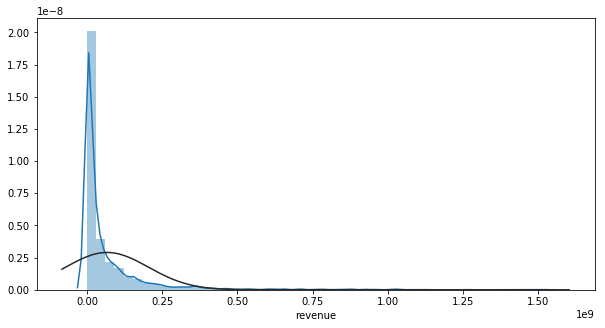

In [28]:
from scipy.stats import norm

plt.subplots(figsize=(10,5))
sns.distplot(train_clean['revenue'], fit=norm)
plt.show()

The model is heavily right-skewed, hence linear models will have a hard time predicting. To correct this we can log-transform the revenue.

In [29]:
train_clean['log_revenue'] = np.log1p(train_clean['revenue'])

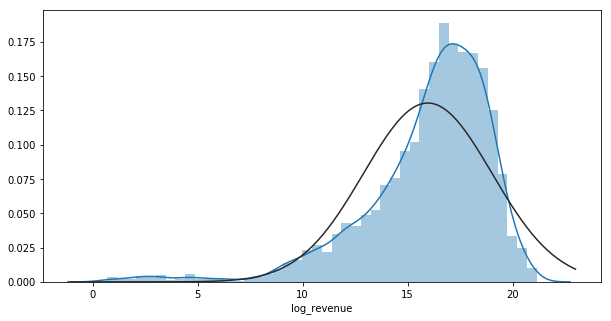

In [30]:
plt.subplots(figsize=(10,5))
sns.distplot(train_clean['log_revenue'], fit=norm)
plt.show()

That will have to do.

### 2.2 Multivariate on revenue

#### 2.2.1 On Continous variables.
There are only 3 that fit the idea of a continous variable: **budget**, **popularity** and **runtime**. Let's examine their effects on the predicted variable.

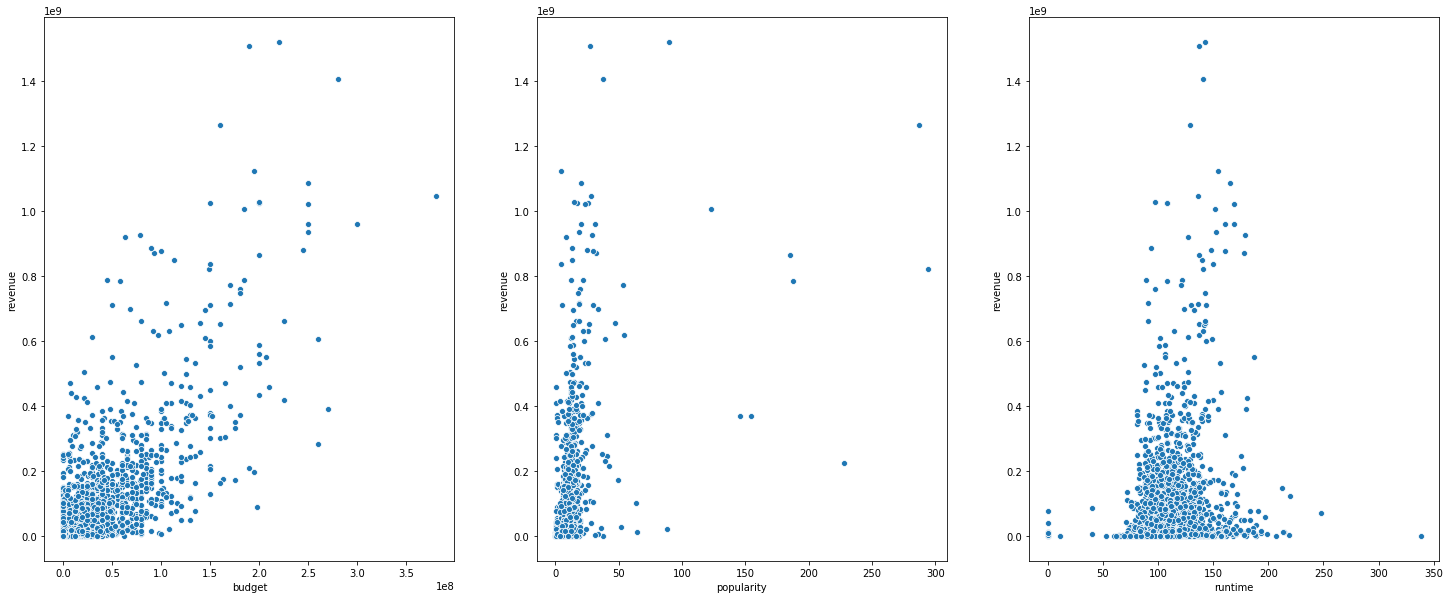

In [31]:
_, axes = plt.subplots(1, 3, figsize=(25, 10))
sns.scatterplot(x='budget', y='revenue', data=train_clean, ax=axes[0])
sns.scatterplot(x='popularity', y='revenue', data=train_clean, ax=axes[1])
sns.scatterplot(x='runtime', y='revenue', data=train_clean, ax=axes[2])
plt.show()

## 3. Feature Engineering.

### 3.1. Handle Genres
To handle genres I will first transform it to a number of matrices representing the various genres - one-hot encoded. I've decided upon this method because a movie can be various genres at the same time.

But first - let's get the unique genres.

In [32]:
def get_unique_genre_list(df):
    '''
    gets the original dataframe and return an object containing the unique genres and their ids.
    '''
    # construct the list of genres
#     genres_col = df['genres']
    genres_list = []
    for item in df['genre_lists']:
        genres_list += item
    
    # construct the lists for both ids and genres
    genre_string_list = []
    genre_id_list = []
    for movie in genres_list:
        genre_string_list.append(movie['name'])
        genre_id_list.append(movie['id'])
    # filter for unique
    unique_ids = []
    unique_genres = []
    unique_id_str = []
    for i in range(0, len(genre_id_list)):
        if genre_id_list[i] not in unique_ids:
            unique_ids.append(genre_id_list[i])
            unique_genres.append(genre_string_list[i])
            unique_id_str.append({'id': genre_id_list[i], 'name': genre_string_list[i]})
            
    return {
        'genre_strings': unique_genres,
        'genre_id': unique_ids,
        'genre_id_str': unique_id_str
        }

In [33]:
genre_list_train = get_unique_genre_list(train_df)

In [34]:
train_sorted_list = sorted([genre['id'] for genre in genre_list_train['genre_id_str']])

In [35]:
genre_list_test = get_unique_genre_list(test_df)

In [36]:
test_sorted_list = sorted([genre['id'] for genre in genre_list_test['genre_id_str']])

In [37]:
genre_list_train['genre_id_str']

[{'id': 35, 'name': 'Comedy'},
 {'id': 18, 'name': 'Drama'},
 {'id': 10751, 'name': 'Family'},
 {'id': 10749, 'name': 'Romance'},
 {'id': 53, 'name': 'Thriller'},
 {'id': 28, 'name': 'Action'},
 {'id': 16, 'name': 'Animation'},
 {'id': 12, 'name': 'Adventure'},
 {'id': 27, 'name': 'Horror'},
 {'id': 99, 'name': 'Documentary'},
 {'id': 10402, 'name': 'Music'},
 {'id': 80, 'name': 'Crime'},
 {'id': 878, 'name': 'Science Fiction'},
 {'id': 9648, 'name': 'Mystery'},
 {'id': 10769, 'name': 'Foreign'},
 {'id': 14, 'name': 'Fantasy'},
 {'id': 10752, 'name': 'War'},
 {'id': 37, 'name': 'Western'},
 {'id': 36, 'name': 'History'},
 {'id': 10770, 'name': 'TV Movie'}]

In [38]:
def create_is_genre_columns(df):
    # create the neccery columns in df and assign its value to 0
    for genre in genre_list_train['genre_strings']:
        df['is_' + genre] = 0
    
    return df

In [39]:
train_clean = create_is_genre_columns(train_clean)
test_clean = create_is_genre_columns(test_clean)

In [40]:
def fill_genre_columns(df):
    '''
    It fills the precreated is_Genre columns, depending on the contents of the genre column.
    '''
    for idx, row in df.iterrows():
        genres = df.loc[idx, 'genre_lists']
        for genre in genres:
            df.loc[idx, 'is_' + genre['name']] = 1
    
    return df

In [41]:
def drop_genres_column(df):
    '''
    Drops the genre_list column
    '''
    df = df.drop(['genre_lists'], axis=1)
    return df

In [42]:
train_clean = fill_genre_columns(train_clean)

In [43]:
train_clean = drop_genres_column(train_clean)

-- Dealing with the test set.

In [44]:
test_clean = fill_genre_columns(test_clean)
test_clean = drop_genres_column(test_clean)

In [45]:
train_clean.shape, test_clean.shape

((3000, 42), (4398, 40))

In [46]:
train.shape, test.shape

((3000, 23), (4398, 22))

### 3.x Handle Cast

**Already handled during cleaning**

At first I was thinking in the lines of listing the movies with the highest revenue and using their cast as a benchmark of whether the other movies have popular actors in them, but this approach has many flaws - some top billed actors do act in movies that do not bring a large sum, and in addition top grossing movies may include not so many famous actors.  

However there might be relationships worth exploring between the number of the billed cast, the number of representation of each genders (as the dataset graciously includes their gender).

### 3.x Handling Production Companies
**Already handled during cleaning**

The same approach as cast - lets see if we can get the number of companies that collaborate on a movie.

### 3.x Handling Production Countries
**Already handled during cleaning**  
Copying the approach from the previous two points - I'll just count the number of countries, which participated in making the movie.

### 3.5 Dropping the unnecessary columns
The following columns are not needed:
1. imdb_id
2. poster_path

In [47]:
def drop_unused_columns(df):
    for col in ['imdb_id']:
        df = df.drop(col, axis=1)
    
    return df

In [48]:
train_clean = drop_unused_columns(train_clean)
test_clean = drop_unused_columns(test_clean)

### 3.6 Handling language - both original and spoken

- original_language - one-hot encode the column
- spoken_language
    - number of languages spoken
    - categorical - is the movie multilingual
    - is the movie targeted only to the local market - if the spoken language is the only original language

#### -- Dealing with original language

In [49]:
def encode_original_languages(df):
    '''
        Encode the original languages with one-hot encoding
    '''
    language_dummies = pd.get_dummies(df['original_language']).astype('int64')
    return pd.concat([df, language_dummies], axis=1)

def drop_original_language(df):
    '''
        Dropping the original language column.
    '''
    return df.drop('original_language', axis=1)

In [50]:
train_clean = encode_original_languages(train_clean)
test_clean = encode_original_languages(test_clean)

Validate if train and test have the same number of spoken columns!

In [51]:
# a bit crude but for the sake of tests
for col in ['af', 'bm', 'ca', 'cs', 'is', 'ka', 'kn', 'th', 'xx']:
    train_clean[col] = 0

In [52]:
for col in ['ar', 'fa', 'nb', 'mr', 'vi']:
    test_clean[col] = 0

#### -- Dealing with spoken languages
--- Getting number of spoken languages

In [53]:
def get_num_spoken_languages(df):
    '''
        Get the number of spoken languages per movie
    '''
    df['num_spoken_languages'] = 0
    for index, row in df.iterrows():
        df.loc[index, 'num_spoken_languages'] = len(ast.literal_eval(row['spoken_languages']))
        
    return df

In [54]:
train_clean = get_num_spoken_languages(train_clean)
test_clean = get_num_spoken_languages(test_clean)

--- Spoken Language - same with the original language

In [55]:
def spoken_original_language(df):
    '''
        Checking whether the spoken language is the only one and if it is the same with the original.
        If the languages match - indicate as 1, else 0
    '''
    # iso_639_1
    df['original_spoken_match'] = 0
    for index, row in df.iterrows():
        if len(ast.literal_eval(row['spoken_languages'])) == 1:
#             if type(ast.literal_eval(row['spoken_languages'])) != type([]):
#                 print(row['spoken_languages'])
            if ast.literal_eval(row['spoken_languages'])[0]['iso_639_1'] == row['original_language']:
                df.loc[index, 'original_spoken_match'] = 1
    
    return df

In [56]:
train_clean = spoken_original_language(train_clean)
test_clean = spoken_original_language(test_clean)

In [57]:
train_clean = train_clean.drop('spoken_languages', axis=1)
test_clean = test_clean.drop('spoken_languages', axis=1)

In [58]:
train_clean = drop_original_language(train_clean)
test_clean = drop_original_language(test_clean)

### 3.7 Handling dates
Quite a lot of information can be extracted from the dates:
* Handling day
    * Day number - as indicated in the string
    * Day of the week - from 1 to 7
    * Week Number - probably redundant and highly correlated with the data from the months.
* Handling month
    * Month number
* Handling year
    * Year Number 

In [59]:
#train_clean['released_date'].apply(lambda x: datetime.strptime(x, '%m/%d/%y')
def add_proper_time(df):
    df['release_date_proper'] = df['release_date'].apply(lambda x: datetime.strptime(x, '%m/%d/%y'))
    return df

In [60]:
train_clean = add_proper_time(train_clean)
test_clean = add_proper_time(test_clean)

#### --- Creating validator function
The goal of this function is to validate that the respective columns fall in a range of numbers - f.e. days' numbers shouldn't be higher than 31, while months should be higher than 12

In [61]:
def range_validator(range_start, range_end, column, df):
    '''
        Checks whether the data falls between the range defined. Return true if correct - false otherwise.
    '''
    if df[(df[column] > range_end) & (df[column] < range_start)].shape[0] == 0:
        return True
    else:
        return False

#### --- Creating day features

In [62]:
def handle_days(df):
    '''
        Create 3 features - day number of the month, day of the week and week number
    '''
    # getting day numbers
    df['date_day_number'] = df['release_date_proper'].apply(lambda x: x.day)
    # day of the week
    df['date_day_week_day'] = df['release_date_proper'].apply(lambda x: x.dayofweek)
    # week number
    df['date_week_number'] = df['release_date_proper'].apply(lambda x: x.weekofyear)
    
    return df

In [63]:
train_clean = handle_days(train_clean)
test_clean = handle_days(test_clean)

**Validating day data:**  
The day number shouldn't be bigger than 31 and shouldn't be below 1, while the days of the week, since they start from 0 should be between 0 and 6, and the week number should lay between 1 and 52.

In [64]:
range_validator(1, 31, 'date_day_number', train_clean), range_validator(1, 31, 'date_day_number', test_clean)

(True, True)

In [65]:
range_validator(0, 6, 'date_day_week_day', train_clean), range_validator(0, 6, 'date_day_week_day', test_clean)

(True, True)

In [66]:
range_validator(1, 52, 'date_week_number', train_clean), range_validator(1, 52, 'date_week_number', test_clean)

(True, True)

All 3 features validate succesfully.

#### --- Creating month features

In [67]:
def handle_months(df):
    '''
        Create 2 features, related to month - month number and season
    '''
    # getting month numbers
    df['date_month_number'] = df['release_date_proper'].apply(lambda x: x.month)
    
    return df

In [68]:
train_clean = handle_months(train_clean)
test_clean = handle_months(test_clean)

**Validating Month Numbers:**  
Let's check if for some reason we have month numbers that are bigger than 12 and less than 1.

In [69]:
range_validator(1, 12, 'date_month_number', train_clean), range_validator(1, 12, 'date_month_number', test_clean)

(True, True)

No rows have a month number bigger than 12 or smaller than 1.

#### --- Creating year features

In [70]:
def handle_years(df):
    '''
        Create just one feature, related to year - the year's number.
    '''
    df['date_year_number'] = df['release_date_proper'].apply(lambda x: x.year)
    
    return df

In [71]:
train_clean = handle_years(train_clean)
test_clean = handle_years(test_clean)

**Validating year numbers:**  
This time the year numbers are 'more' arbitrary that the other features - let's say that below 1900 there were no movies and beyond 2019 (this year) there should be any movies.

In [72]:
range_validator(1900, 2019, 'date_year_number', train_clean), range_validator(1900, 2019, 'date_year_number', test_clean)

(True, True)

All good.

#### --- Dropping the release date column as well as the timestamp encoded one.

In [73]:
train_clean = train_clean.drop('release_date', axis=1)
test_clean = test_clean.drop('release_date', axis=1)
###
train_clean = train_clean.drop('release_date_proper', axis=1)
test_clean = test_clean.drop('release_date_proper', axis=1)

*Note*: Drop the following before features can be extracted - status, title, keywords, crew, original_title, overview

In [74]:
train_clean = train_clean.drop(['status','title'], axis=1)
test_clean = test_clean.drop(['status','title'], axis=1)

In [75]:
train_clean = train_clean.drop(['original_title'], axis=1)
test_clean = test_clean.drop(['original_title'], axis=1)

In [76]:
train.shape, test.shape

((3000, 23), (4398, 22))

In [77]:
train_clean.shape, test_clean.shape

((3000, 86), (4398, 84))

### 3.8 Scaling numerical features.

Let's investigate if the numerical features ('budget', 'popularity') need scaling and how I'll go around that.

In [78]:
train_clean.describe()[['budget', 'popularity']]

,budget,popularity
count,3.000000e+03,3000.000000
mean,2.253133e+07,8.463274
std,3.702609e+07,12.104000
min,0.000000e+00,0.000001
25%,0.000000e+00,4.018053
50%,8.000000e+06,7.374861
75%,2.900000e+07,10.890983
max,3.800000e+08,294.337037


The simple answer is - definately. As it can be seen from the table above the budget has a very wide range, while popularity also has orders of magnitude and it seems that, looking at the quartile values, that they scale very fast. Let's visualize them to explore them.

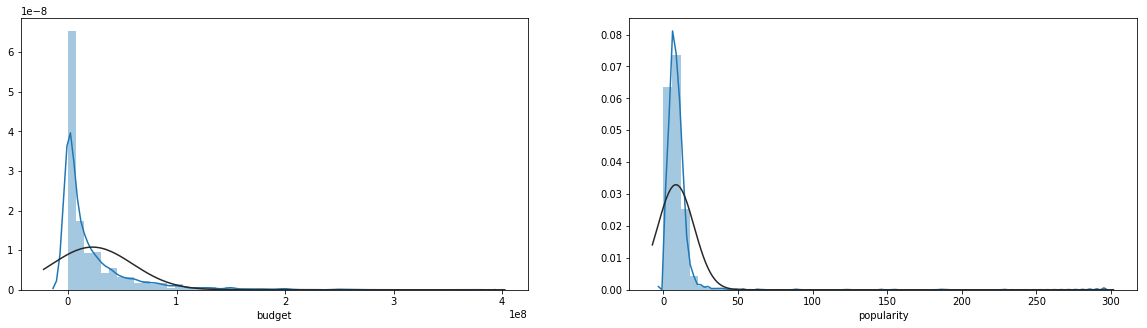

In [79]:
_, axes = plt.subplots(1, 2, figsize=(20, 5))
sns.distplot(train_clean['budget'], fit=norm, ax=axes[0])
sns.distplot(train_clean['popularity'], fit=norm, ax=axes[1])
plt.show()

As it can be seen from the plots it seems that both have exponential curves. We need to scale them.

In [80]:
from sklearn.preprocessing import MinMaxScaler

def scale_numericals(df):
    '''Scale the numerical values regarding the budget and popularity'''
    sc = MinMaxScaler()
    df['scaled_budget'] = sc.fit_transform((df['budget'].values).reshape(-1,1))
    df['scaled_popularity'] = sc.fit_transform((df['popularity'].values).reshape(-1,1))
    
    return df

In [81]:
def log_transform(df):
    '''Log transform the values in the budget and popularity columns'''
    df['log_budget'] = np.log1p(df['budget'])
    df['log_popularity'] = np.log1p(df['popularity'])
    
    return df

In [82]:
def drop_columns_budget_pop(df):
    df = df.drop(['budget', 'popularity'], axis=1)
    return df

In [83]:
# train_clean = scale_numericals(train_clean)
train_clean = log_transform(train_clean)
train_clean = drop_columns_budget_pop(train_clean)

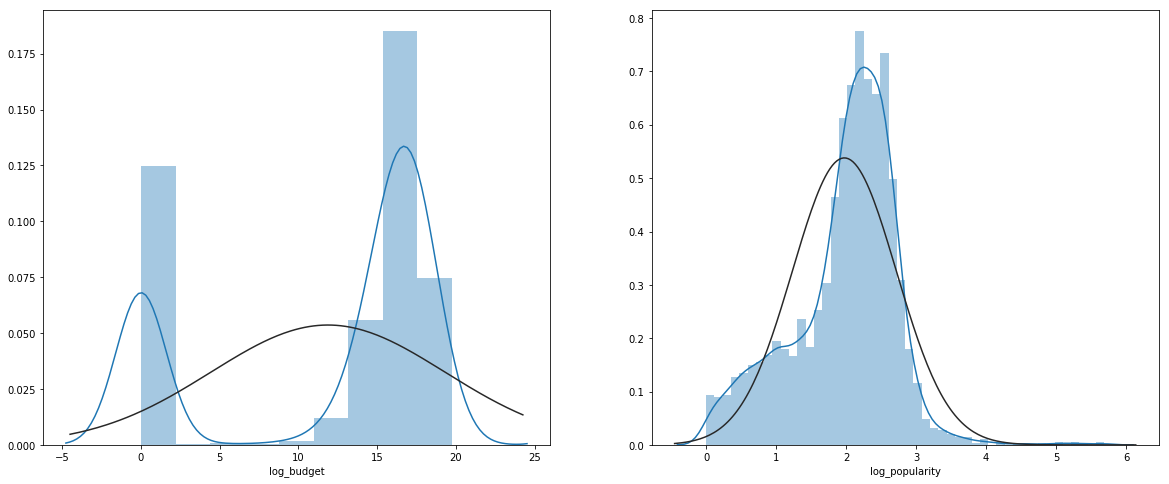

In [88]:
_, axes = plt.subplots(1, 2, figsize=(20, 8))
sns.distplot(train_clean['log_budget'], fit=norm, ax=axes[0])
sns.distplot(train_clean['log_popularity'], fit=norm, ax=axes[1])
# sns.distplot(train_clean['scaled_budget'], fit=norm, ax=axes[1, 0])
# sns.distplot(train_clean['scaled_popularity'], fit=norm, ax=axes[1, 1])
plt.show()

In [89]:
# test_clean = scale_numericals(test_clean)
test_clean = log_transform(test_clean)
test_clean = drop_columns_budget_pop(test_clean)

## 4. Modelling

In [90]:
# importing the metric
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score, train_test_split
# importing the regressors
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.model_selection import GridSearchCV

In [91]:
#### Model Execturor
class ModelExecuter:
    def __init__ (self, models, train_x, train_y, test_x=None, test_y=None):
        self.models = models
        self.train_x = train_x
        self.train_y = train_y
        self.test_x = test_x
        self.test_y = test_y
    
    def rmse(self, predicted_y):
        return np.sqrt(mean_squared_error(self.test_y, predicted_y))
    
    def rmse_cv(self, nfolds):
        kfolds = KFold(nfolds, random_state=42).get_n_splits(self.train_x)
        for model in self.models:
            rmse = np.sqrt(-cross_val_score(model, self.train_x, self.train_y, scoring='neg_mean_squared_error', cv=kfolds))
            print('{}: {:.4f}'.format(type(model).__name__, rmse.mean()))
    
    def fit_all(self):
        for model in self.models:
            model.fit(self.train_x, self_train_y)
        return self
    
    def get_score_all(self):
        for model in self.models:
            model_y_predicted = model.predict(self.test_x)
            print('{}: {}'.format(type(model).__name__, self.rmse(model_y_predicted)))
            
    def predict_specific(self, model_name, testx=None):
        testx = testx if testx is not None else self.test_x
        
        for model in self.models:
            if type(model).__name__ == model_name:
                rgrs = model.fit(self.train_x, self.train_y)
                return rgrs.predict(testx)
    
    def fit_base_models(self, x_train, y_train, x_test, nfolds):
        df_train = pd.DataFrame()
        df_test = pd.DataFrame()
        
        for model in self.models: # generate on a separate fold of models
            kfolds = KFold(nfolds, random_state=42)
            
            _train = np.zeros((x_train.shape[0],))
            _test = np.zeros((x_test.shape[0],))
            _test_skf = np.zeros((nfolds, x_test.shape[0]))
            
            i = 0
            for train_index, test_index in kfolds.split(x_train):
                x_tr = x_train[train_index]
                y_tr = y_train[train_index]
                x_te = x_train[test_index]
                
                model.fit(x_tr, y_tr)
                _train[test_index] = model.predict(x_te)
                _test_skf[i, :] = model.predict(x_test)
                i = i + 1
                
            _test[:] = _test_skf.mean(axis=0)
            
            df_train[type(model).__name__] = _train
            df_test[type(model).__name__] = _test
            
        return df_train.values, df_test.values

In [92]:
models = [LinearRegression(), 
         Lasso(alpha=0.01, random_state=42), 
         Ridge(alpha=1, random_state=42),
         ElasticNet(alpha=0.005, l1_ratio=0.7),
         AdaBoostRegressor(n_estimators=100, learning_rate=0.01, random_state=42),
         ExtraTreesRegressor(n_estimators=2000, n_jobs=-1),
         GradientBoostingRegressor(n_estimators=3000, learning_rate=0.01, max_depth=4, max_features='sqrt'),
         RandomForestRegressor(n_estimators=3000, max_depth=6, max_features='sqrt', n_jobs=-1)]

In [93]:
def split_predictors(df, predicted_var):
    '''Returns two numpy arrays - of the predictors and the predicted variable.'''
    data = df.copy()
    y = data[predicted_var].values
    data = data.drop(['id', 'log_revenue','revenue'], axis=1)
    # Drop ID as we don't need it.
    x = data.values
    
    return x, y, data

In [94]:
X_train, y_train, ref = split_predictors(train_clean, 'log_revenue')

In [95]:
regressors = ModelExecuter(models, X_train, y_train)

In [96]:
regressors.rmse_cv(nfolds=5)

LinearRegression: 2.2761
Lasso: 2.2579
Ridge: 2.2673
ElasticNet: 2.2604
AdaBoostRegressor: 2.2772
ExtraTreesRegressor: 2.1158
GradientBoostingRegressor: 2.0952
RandomForestRegressor: 2.2879


#### -- Generating The new training and test set for stacking model

In [97]:
test_clean2 = test_clean.copy()
test_clean2 = test_clean2.drop(['id'], axis=1)
x_test = test_clean2.values

In [98]:
x_train_meta, x_test_meta = regressors.fit_base_models(X_train, y_train, x_test, 5)

-- Creating the meta regressor

In [99]:
import xgboost

In [100]:
xgb_model = xgboost.XGBRegressor(learning_rate=0.1, n_estimators=1000, max_depth=5, 
                                 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, 
                                 nthread=6, scale_pos_weight=1, seed=27)

In [101]:
# fit
xgb_model.fit(x_train_meta, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
       nthread=6, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8)

#### -- GridSearch for the base models

In [236]:
class ModelParamEstimator:
    def __init__ (self, models, model_params_dict, X, y):
        self.models = models
        self.model_params_dict = model_params_dict
        self.X = X
        self.y = y
        
    def evaluate_params (self, nfolds=5):
        best_params = {}
        
        for model in self.models:
            # Check if model in param_grid
            if type(model).__name__ not in self.model_params_dict.keys():
                continue
            # Get the param grid    
            param_grid = self.model_params_dict[type(model).__name__]
            grid_search = GridSearchCV(model, param_grid, cv=nfolds)
            grid_search.fit(self.X, self.y)
            best_params[type(model).__name__] = grid_search.best_params_
        
        return best_params

In [303]:
models_to_eval = [LinearRegression(), 
                 Lasso(random_state=42), 
                 Ridge(random_state=42),
                 AdaBoostRegressor(random_state=42),
                 ExtraTreesRegressor(max_features='sqrt', random_state=42, n_jobs=-1),
                 GradientBoostingRegressor(max_features='sqrt'),
                 RandomForestRegressor(max_features='sqrt', n_jobs=-1)]

models_param_grid_dict = {
        'Ridge': {'alpha': [0, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]},
        'Lasso': {'alpha':[0, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]},
        'ElasticNet': {'alpha': [0, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1], 
                      'l1_ratio': [0.05, 0.1, 0.5]},
        'AdaBoostRegressor': {'n_estimators':[100, 500, 1000, 2000, 3000], 
                              'learning_rate':[0.01, 0.05, 0.1, 1]},
        'ExtraTreesRegressor':{'n_estimators':[100, 500, 1000, 2000, 3000]},
        'GradientBoostingRegressor': {'n_estimators':[100, 500, 1000, 2000, 3000], 
                                      'learning_rate':[0.01, 0.05, 0.1, 1], 'max_depth':[1,2,3,4,5,6]},
        'RandomForestRegressor': {'n_estimators':[100, 500, 1000, 2000, 3000], 'max_depth':[1,2,3,4,5,6]}
}

In [304]:
param_estimator = ModelParamEstimator(models_to_eval, models_param_grid_dict, X, y)
best_params = param_estimator.evaluate_params()

In [305]:
best_params

{'Lasso': {'alpha': 0.01},
 'Ridge': {'alpha': 1},
 'AdaBoostRegressor': {'learning_rate': 0.01, 'n_estimators': 100},
 'ExtraTreesRegressor': {'n_estimators': 2000},
 'GradientBoostingRegressor': {'learning_rate': 0.01,
  'max_depth': 4,
  'n_estimators': 3000},
 'RandomForestRegressor': {'max_depth': 6, 'n_estimators': 3000}}

## 5. Submitting Predictions

In [102]:
predictions = xgb_model.predict(x_test_meta)

In [103]:
predictions_df = pd.DataFrame({'id':test_clean.iloc[:, 0], 'revenue':np.expm1(predictions)})

In [104]:
predictions_df.to_csv('./submissions/TMDB_Box_Office_Predictions_20190510.csv', index=False)